# Super Classy

# Sentiment Analysis of Climate Change Perception on Twitter using Classification Techniques

## Team Members 
- Katlego Thobye
- Njabulo Nxumalo
- Thato Matlou
- Seema Masekwameng
- Khuthadzo Mamushiana
- Matlala Nyama
- Lerato Ntoene

## Table of Contents

- Introduction
    - Predict Overview
    - Import Packages
    - Loading Data
- Loading Data
- Exploratory Data Analysis
- Feature Engineering
- 

## Introduction

In today's world, where climate change is a pressing global concern, understanding public sentiment towards this issue is of paramount importance for companies seeking to align their marketing strategies with societal perspectives. By accurately gauging public perception and identifying potential threats associated with climate change, companies can develop targeted campaigns that resonate with diverse consumer sentiments and effectively address their concerns. This report presents a comprehensive analysis utilizing Jupyter Notebook to classify the sentiment of tweets related to climate change, providing valuable insights for companies in shaping their future marketing strategies.

## Objective and Mission

The primary objective of this project is to deliver a precise and durable solution that enables companies to gain insights into how people perceive climate change and assess whether it is perceived as a real threat. By leveraging cutting-edge classification techniques, our mission is to equip companies with a tool that taps into a wide range of consumer sentiments across various demographics and geographic regions. Through this, we aim to enhance their understanding of public perception and empower them to shape future marketing strategies based on valuable insights gleaned from social media data.

## Methodology

To achieve our objective, we employ classification techniques within the Jupyter Notebook environment. The core methodology revolves around training a classification model using a pre-labeled dataset, which encompasses tweets related to climate change. By leveraging this labeled dataset, we can effectively train our model to predict the sentiment of novel tweet data accurately.

Utilizing machine learning algorithms and natural language processing techniques, we develop a robust classification model that can analyze and classify sentiments expressed in tweets. This model takes into account various features of the tweet, such as the text content, contextual information, and linguistic patterns, to make sentiment predictions.

## Initializing Comet Experiments

In [1]:
import comet_ml

In [2]:
from comet_ml import Experiment
experiment = Experiment(
  api_key = "TmIAhAxCYHRZd3q9SzUZ1tenu",
  project_name = "twitter-sentiment-classification",
  workspace="xuzmocode4-325"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/xuzmocode4-325/twitter-sentiment-classification/00a1ca52bba440df9cdecd922fda7f04



## Exploratory Data Analysis (EDA)

### Importing Essential Packages

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization
import matplotlib.style as style # style selection for visuals
%matplotlib inline 
import nltk # natural language processing platform
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re # regular expressions for text processing
import string # python library for string processing
nltk.download('stopwords') 
from nltk.corpus import stopwords
from wordcloud import WordCloud 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Setting Up Constants

In [5]:
style.use('Solarize_Light2')
# standard dimensions for visuals
l = 11 #visual length   
w = 6 #visual width

### Loading Data

Our data set consists of two features and a label. The main feature is the `message` column that contains a tweet related to global warming. The label `sentiment` catagorizes tweets according to four classes, namely `news`, `neutral`, `pro` and `anti`. Our aim will be to create a machine learning model that will be able to acurately classify any tweet according to these four buckets based on the textual message data of a tween only. 

In [6]:
df_train = pd.read_csv("train.csv")
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [7]:
df_test = pd.read_csv("test_with_no_labels.csv")
df_test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


There are `15819 categorized observations` in the train dataset and `10546 uncategorized observations` in the test dataset. 

In [8]:
print("There are", df_train.shape[0], "categorized observations.")
print("There are", df_test.shape[0], "uncategorized observations.")

There are 15819 categorized observations.
There are 10546 uncategorized observations.


There are no null values in either the train or test datasets.

In [9]:
#check null values
print("There are", df_train.isnull().sum().sum(), "null values in the train dataset.") 
print("There are", df_test.isnull().sum().sum(), "null values in the test dataset.")

There are 0 null values in the train dataset.
There are 0 null values in the test dataset.


The `tweetid` feature simply uniquely identifies each tweet and most probably will add no real value in classification machine model training.

In [10]:
df_train['tweetid'].nunique()

15819

In [11]:
train_proxy = df_train.copy()
train_proxy.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In order to analyze the length of tweets, we created a new feature called `size` which is a count of the `number of characters per tweet`.

In [12]:
size = [len(tweet) for tweet in df_train['message']]
train_proxy['size'] = size

The tweets range from `14` to `208` characters in length. The average size of a tweet is about `124` characters long. Most tweets are `140` characters in length.

In [13]:
print("The shortest tweet is", train_proxy['size'].min(), "characters in length.")
print("The longest tweet is", train_proxy['size'].max(), "characters in length.")
print("Most tweets are", train_proxy['size'].mode()[0], "characters in length.")
print("The average tweets is", round(train_proxy['size'].mean()), "characters in length.")
print("The median tweet is", round(train_proxy['size'].median()), "characters in length.")
train_proxy['size'].describe()


The shortest tweet is 14 characters in length.
The longest tweet is 208 characters in length.
Most tweets are 140 characters in length.
The average tweets is 124 characters in length.
The median tweet is 133 characters in length.


count    15819.000000
mean       123.774132
std         23.332433
min         14.000000
25%        114.000000
50%        133.000000
75%        140.000000
max        208.000000
Name: size, dtype: float64

### Visualizing Analysis Data

#### Tweet Length Distribution

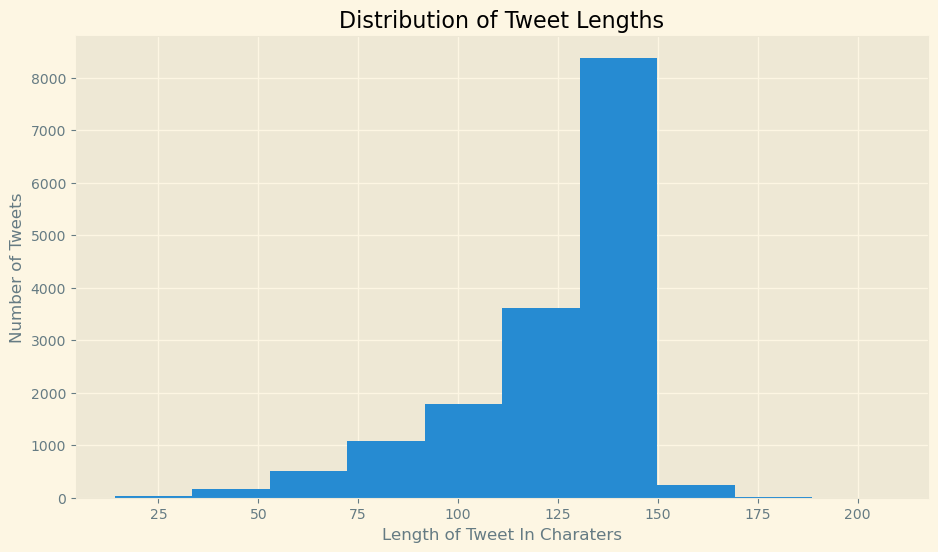

In [14]:
plt.figure( figsize=(l,w))
plt.hist(train_proxy['size'])
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Length of Tweet In Charaters") #X-label of the data
plt.ylabel("Number of Tweets")      #Y_label of the data
plt.show()

#### Box Plots on Tweet Length

Below we attempt to visualize the `5 number summary` of each category of tweet as well as the dataset as a whole using `box and whiskers` diagrams. 

In [15]:
#creating class subsets for the datase

df_anti = train_proxy.copy()[df_train['sentiment'] == -1]
df_neutral = train_proxy.copy()[df_train['sentiment'] == 0]
df_pro = train_proxy.copy()[df_train['sentiment'] == 1]
df_news = train_proxy.copy()[df_train['sentiment'] == 2]

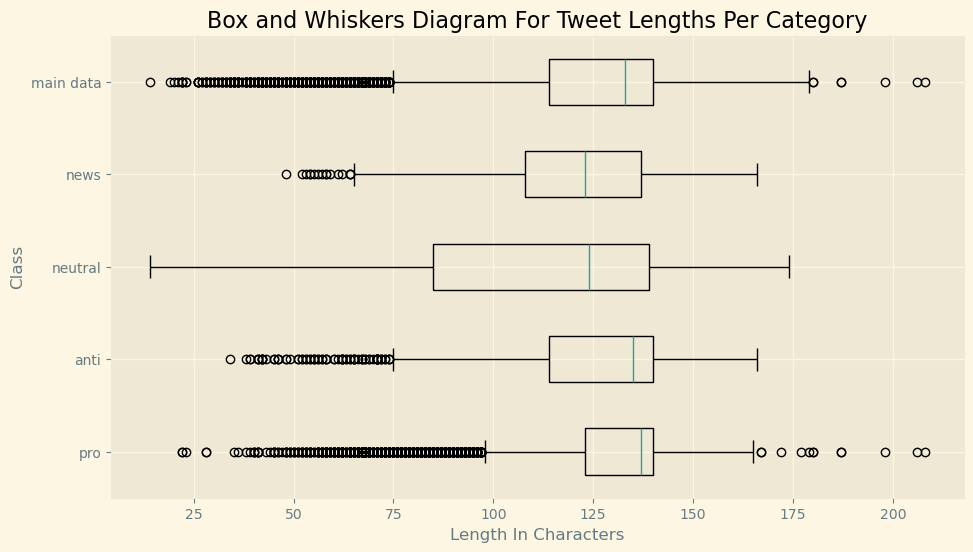

In [16]:
#storing the size data in separate variables

pro_len = df_pro['size']
neutral_len = df_neutral['size']
anti_len = df_anti['size']
news_len = df_news['size']
data_len = train_proxy['size']

#creating a list of all the length datasets

len_data = [pro_len, anti_len, neutral_len, news_len, data_len]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(l,w))

# Create the box plots
ax.boxplot(len_data, vert=False)

# Set the labels for each box plot
labels = ['pro', 'anti', 'neutral', 'news', 'main data']
ax.set_yticklabels(labels)

# Set the title and axis labels
plt.title('Box and Whiskers Diagram For Tweet Lengths Per Category')
plt.xlabel('Length In Characters')
plt.ylabel('Class')

# Show the plot
plt.show()

#### Raw Text Wordcloud 

In [17]:
text =" ".join(i for i in df_train["message"])
text = str(text)

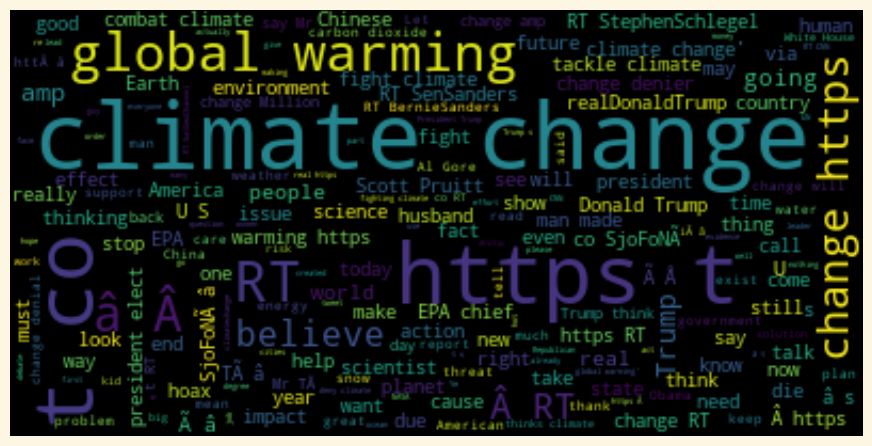

In [18]:
wordcloud = WordCloud()
tweet_cloud = wordcloud.generate(text)
plt.figure( figsize=(l,w))
plt.imshow(tweet_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In the raw text `wordcloud` diagram we see many words not related to natural human language, the most prominent being `https` which in a tweet context is probably associated with external links to websites on the internet beyond Twitter. In order to only make predictions based on the texts related to natural language the message feature must be cleaned so that only those parts of a tweet remain. 

### Cleaning Data

In [19]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon')
from wordcloud import WordCloud,ImageColorGenerator

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\katle\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In order to process the tweet messages more effectively the tweets are cleaned using the `clean` function defined in the code cell below.
The clean function does the following.
- Converts all tweet text to lowercase.
- Removes URLs.
- Removes punctuation.
- Removes numbers.
- Removes stopwords.
- Removes line-break code syntax.  
- Reduce each word that is not a stop word to a lemma.

In [20]:
# add comments per line
stopword=set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer() 

def clean(text):
    text = str(text).lower() 
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stopword]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    
    return text

In [21]:
train_proxy['clean'] = train_proxy['message'].apply(clean)

In [22]:
train_proxy.head()

,sentiment,message,tweetid,size,clean
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,140,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,62,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,140,rt rawstory researcher say three year act clim...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,99,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,122,rt soynoviodetodas racist sexist climate chang...


In [23]:
train_proxy.isnull().sum().sum()

0

In [24]:
df_train['clean'] = df_train['message'].apply(clean)
df_test['clean'] = df_test['message'].apply(clean)

#### Clean Text Wordcloud

In [25]:
text = " ".join(i for i in train_proxy["clean"]) 

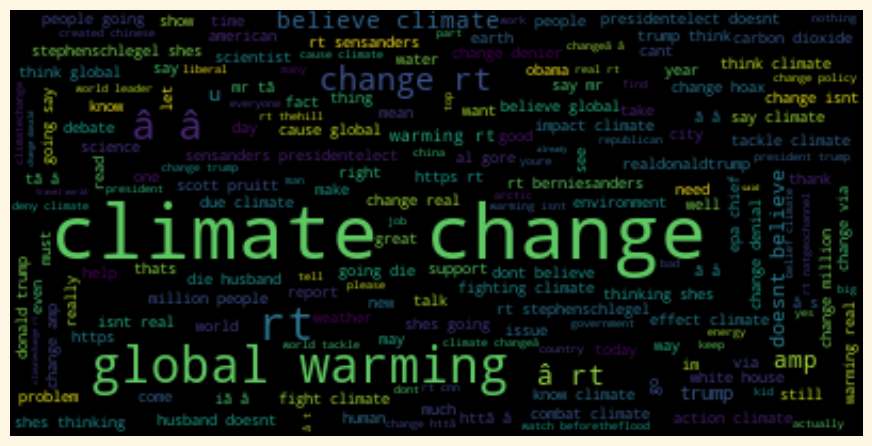

In [26]:
# bilinear
wordcloud = WordCloud()
tweet_cloud = wordcloud.generate(text)
plt.figure( figsize=(l,w))
plt.imshow(tweet_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The clean text `Word Cloud`, shows words in and phrases in natural language that commonly appear in tweets related to global warming and climate change.
The top three phrases seem to be:

- Climate Change
- Global Warming
- RT
- Change RT 
- Believe Climate

#### Pie Chart for Retweet Analysis

In [27]:
has_rt = lambda x: 'rt' in x
train_proxy['rt'] = [1 if has_rt(i) else 0 for i in train_proxy['clean']]
train_proxy.head()


,sentiment,message,tweetid,size,clean,rt
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,140,polyscimajor epa chief doesnt think carbon dio...,0
1,1,It's not like we lack evidence of anthropogeni...,126103,62,like lack evidence anthropogenic global warming,0
2,2,RT @RawStory: Researchers say we have three ye...,698562,140,rt rawstory researcher say three year act clim...,1
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,99,todayinmaker wired pivotal year war climate ch...,0
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,122,rt soynoviodetodas racist sexist climate chang...,1


In [28]:
rt_counts = train_proxy["rt"].value_counts()
rt_counts

rt
1    10579
0     5240
Name: count, dtype: int64

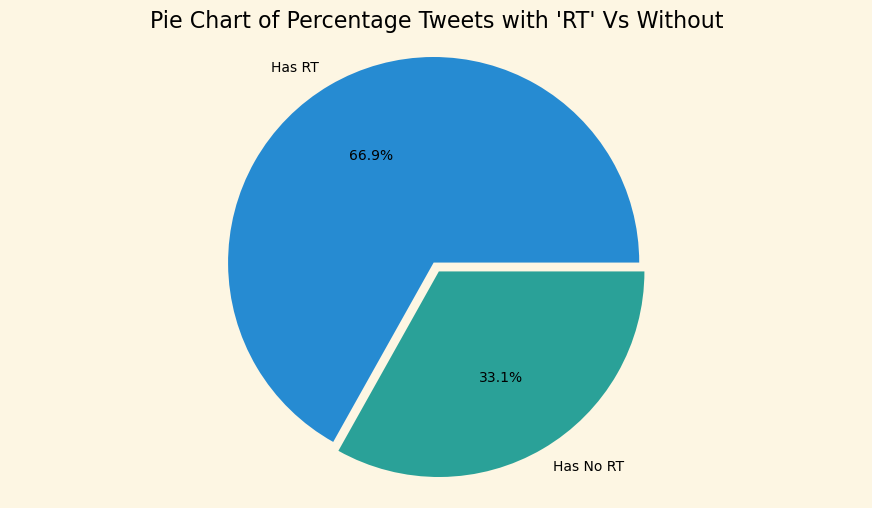

In [29]:
rt_counts = train_proxy["rt"].value_counts()
plt.figure( figsize=(l,w))
plt.pie(rt_counts, labels=["Has RT", "Has No RT"], explode=[0.05,0], autopct='%1.1f%%')
plt.title("Pie Chart of Percentage Tweets with 'RT' Vs Without")
plt.axis('equal')
plt.show()

Most tweets have an `rt` which means it is highly likely if not certain that they are `Retweets`.

According to [twitter.com](https://help.twitter.com/en/using-twitter/retweet-faqs#:~:text=Twitter's%20Retweet%20feature%20helps%20you,re%2Dposting%20someone%20else's%20content.):
 
'A Retweet is a re-posting of a Tweet. Twitter's Retweet feature helps you and others quickly share that Tweet with all of your followers. You can Retweet your own Tweets or Tweets from someone else. Sometimes people type "RT" at the beginning of a Tweet to indicate that they are re-posting someone else's content. This isn't an official Twitter command or feature, but signifies that they are quoting another person's Tweet.'

#### Sentiment Distribution Bar Plot

Plotting the distribution of classes in our dataset we see that most tweets are `Pro` (display belief in) global warming and climate change (more than twice any other class). Other than that, alot of the tweets are `News` related. A fewer amount of the tweets are `Neutral` and the least amount of tweets are `Anti` (show little or no signs of belief in) global warming or climate change. 

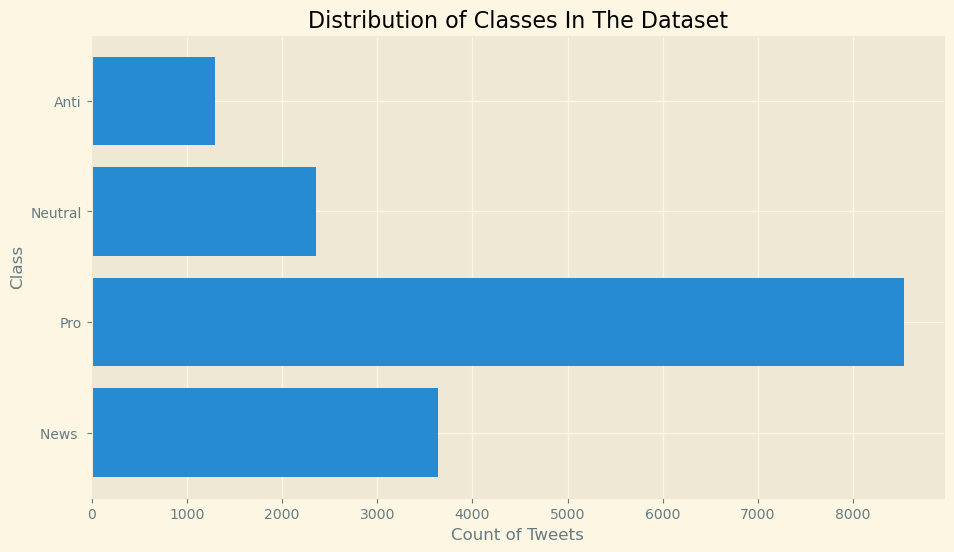

In [30]:
#Create a barplot for the train dataset classes
senti_counts = df_train["sentiment"].value_counts()
news = senti_counts[2] 
pro = senti_counts[1]   
neutral = senti_counts[0]
anti = senti_counts[-1]  

plt.figure( figsize=(l,w))
plt.barh(['News ','Pro','Neutral','Anti'], [news,pro,neutral,anti]) #Use matplotlib horizontal bar graph to compare classes of tweets.
plt.xlabel('Count of Tweets') #X-label of the data
plt.ylabel('Class') #Y_label of the data 
plt.title('Distribution of Classes In The Dataset') #Give the data a title 'Dataset lables distribution'
plt.show() ##Display the dataset


#### Unique Words Counts and Frequency Plot Diagram

Counting how many uniqe words there are in the text body that is the summation of all words in each tweet of the data set will assist in deciding the maximum and minimum threshold parameters for the vectorizer. 

In [31]:
freq_dict = {}
words = text.split(" ")
for word in words:
    if word != " " and word !="":
        if word not in freq_dict:
            freq_dict[word] = 1
        else:
            freq_dict[word] += 1


In [32]:
# Sort the dictionary by values and get the top 20 items
sorted_freq_dict = sorted(freq_dict.items(), key=lambda x:x[1], reverse=True)[:30]
top_30_words = dict(sorted_freq_dict)

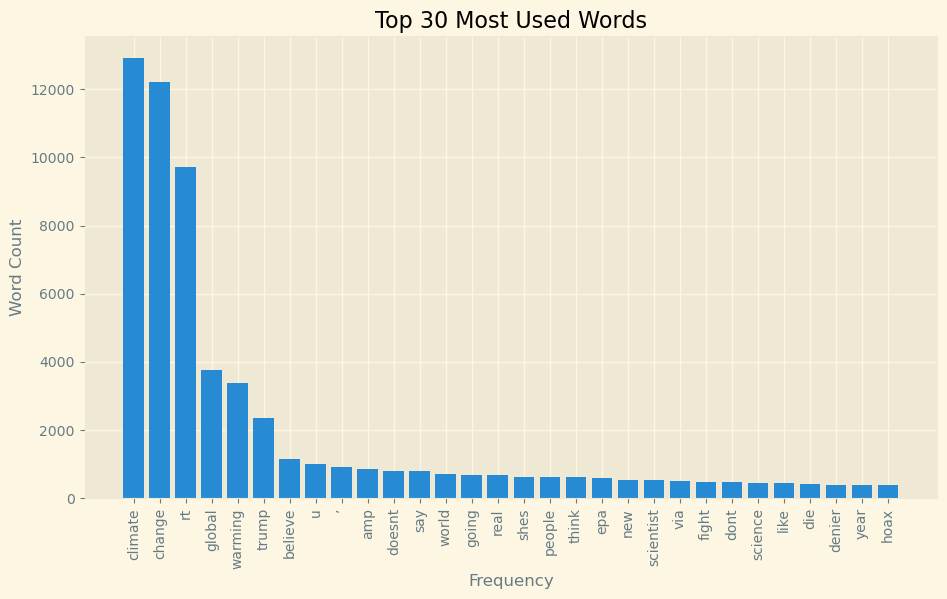

In [33]:
# Extract the x-labels and values from the top 20 data
x_labels = list(top_30_words.keys())
values = list(top_30_words.values())

# Create the figure and axes
fig, ax = plt.subplots(figsize=(l,w))

# Plot the data
ax.bar(x_labels, values)

# Customize the plot
ax.set_xlabel('Frequency')
ax.set_ylabel('Word Count')
ax.set_title('Top 30 Most Used Words')

# Rotate the x-labels if needed
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [34]:
total_words = sum([word for word in freq_dict.values()])
print("The dataset has", total_words, "unique words in total.")

The dataset has 183936 unique words in total.


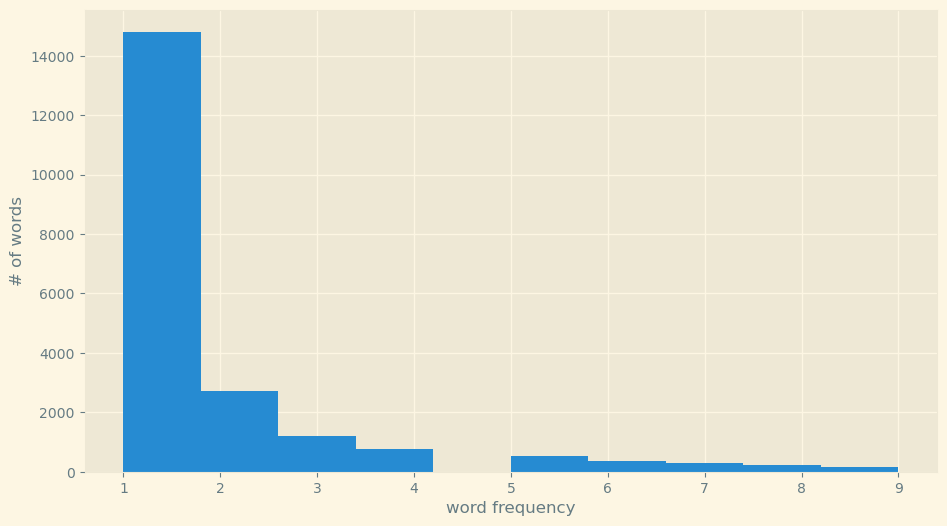

There are 37171 in the dataset that appear below 10 times.


In [35]:
words_under10 =  [word for word in freq_dict.values() if word < 10]
fig, ax = plt.subplots(figsize=(l,w))
plt.hist(words_under10, bins=10)
plt.ylabel("# of words")
plt.xlabel("word frequency")
plt.show()
print("There are", sum(words_under10), "in the dataset that appear below 10 times.")

## Feature Engineering

#### Setting Constants

In [36]:
RSConst = 144
low_lim = 5
upper_lim = 3000

#### Importing Essential Packages

In [37]:
%timeit
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold


#### Importing Classifiers

In [38]:
from sklearn import svm 
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [39]:
id = ['RidgeClassifier','LogisticRegression','RandomForestClassifier', 
        'LinearSVC', 'BernoulliNB', ]
# Storing models in a list for evaluation
method = [RidgeClassifier(random_state=RSConst),
              LogisticRegression(multi_class='ovr', max_iter=90000, solver='saga', random_state=RSConst),
              RandomForestClassifier(bootstrap=True), svm.LinearSVC(multi_class='ovr', max_iter=90000), 
              BernoulliNB()]

#### Importing Preprocessors

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

#### Preparing The Data For Model Training [Non-Resampled]

In [41]:
df_train.head()

,sentiment,message,tweetid,clean
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt rawstory researcher say three year act clim...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt soynoviodetodas racist sexist climate chang...


In [42]:
def performance_tester(X_train, y_train, X_test, y_test, clf_name, clf_type):
    model_stats = {}  # Initialize dictionary to store performance statistics

    for name, clf in zip(clf_name, clf_type):

        model = Pipeline([('vect', TfidfVectorizer(min_df=5, max_df=2000, ngram_range=(1, 3))),
                          ('std', StandardScaler(with_mean=False)),
                          ('clf', clf)])

        model.fit(X_train, y_train)  # Train the model
        result = %timeit -q -o model.fit(X_train, y_train) # Logging a runtime for each model
        model_pred = model.predict(X_test)  # Make predictions on the testing data

        # Compute performance metrics and store in model_stats dictionary
        model_stats[name] = {
            'F1-Macro': metrics.f1_score(y_test, model_pred, average='macro'),
            'F1-Accuracy': metrics.f1_score(y_test, model_pred, average='micro'),
            'F1-Weighted': metrics.f1_score(y_test, model_pred, average='weighted'),
            'Run-Time': result.best
        }

    return pd.DataFrame.from_dict(model_stats, orient='index')

#### Preparing The Data For Model Training [Resampled]

In [43]:
rlen = 3000
news_resampled = resample(df_news, random_state=RSConst, n_samples = rlen) # reproducible results
pro_resampled = resample(df_pro, random_state=RSConst, n_samples = rlen) # reproducible results
anti_resampled = resample(df_anti, random_state=RSConst, n_samples = rlen) # reproducible results
neutral_resampled = resample(df_neutral, random_state=RSConst, n_samples = rlen) # reproducible results

resampled = pd.concat([news_resampled, pro_resampled , anti_resampled, neutral_resampled])
resampled['sentiment'].value_counts()

sentiment
 2    3000
 1    3000
-1    3000
 0    3000
Name: count, dtype: int64

resampled. head()

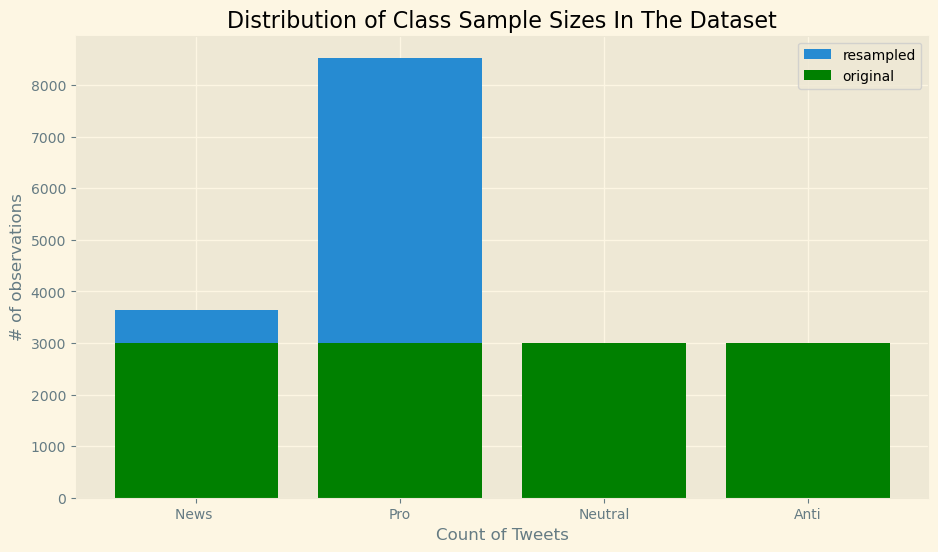

In [44]:
#horizontal bar graph to compare samples of tweets per class.
plt.figure( figsize=(l,w))
len_unsampled = [news, pro, anti, neutral]
resampled_len = [rlen for l in len_unsampled] 
plt.bar(['News ','Pro','Neutral','Anti'], [news,pro,neutral,anti])
plt.bar(['News ','Pro','Neutral','Anti'], resampled_len, color='green')

plt.xlabel('Count of Tweets') #X-label of the data
plt.ylabel('# of observations') #Y_label of the data 
plt.title('Distribution of Class Sample Sizes In The Dataset') #Give the data a title 'Dataset lables distribution'
plt.legend(['resampled','original'])
plt.show() ##Display the dataset

In [45]:
resampled['clean'] = resampled['message']

In [46]:
X = resampled['clean']
y = resampled['sentiment']

In [47]:
X_train, X_test , y_train , y_test = train_test_split(X , y,
                                                       test_size =0.25, 
                                                       random_state=RSConst)

In [48]:
results = performance_tester(X_train, y_train, X_test, y_test, id, method)

c:\Users\katle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\katle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\katle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\katle\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
COMET ERROR: Heartbeat processing error


In [ ]:
results = results.sort_values('F1-Weighted', ascending=False)
results

## Hyperparameter Tuning

In [ ]:
def param_tuning(*args , **kwargs):
  best_params = {}

  for clf in method:
    model = Pipeline([('vect', TfidfVectorizer(min_df=5, max_df=2000, ngram_range=(1, 3))),
                          ('std', StandardScaler(with_mean=False)),
                          ('clf', clf)])
    
    model.fit(X_train, y_train) #Training
    
    #Get models performing parameters
    params = model.get_params()
    model_name = clf.__class__.__name__ 
    model_name = {}
    for key in params:
      if key.startswith("clf"):
        if len(key) < 5:
          model_name['model'] = params[key]
        else:
            model_name[key[5:]] = params[key]
    best_params[clf.__class__.__name__] = model_name
  return best_params

In [ ]:
best_params = param_tuning(method, X_train, y_train)

In [ ]:
best_params

### Conducting Grid Search Cross Validation

In [ ]:
import pickle

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

Setting Up `evaluate` Function for Comet Experiments

In [ ]:
def evaluate(y_test, y_pred):
  return {
      'f1': f1_score(y_test, y_pred, average="weighted"),
      'precision': precision_score(y_test, y_pred, average="weighted"),
      'recall': recall_score(y_test, y_pred, average="weighted")
  }

#### Instantiating The Vectorizer

In [ ]:
scale_vect = Pipeline([('vect', TfidfVectorizer(max_df=2000, min_df=5, ngram_range=(1, 3))),
                          ('scaler', StandardScaler(with_mean=False))])

In [ ]:
X = resampled['clean']
y = resampled['sentiment']

In [ ]:
X_train, X_test , y_train , y_test = train_test_split(X, y,
                                                       test_size =0.4, 
                                                       random_state=RSConst)

In [ ]:
scale_vect.fit(X_train, y_train)

In [ ]:
model_save_path = "../resources/scale_vect.pkl" #pickling the count vectorizer
with open(model_save_path,'wb') as file:
    pickle.dump(scale_vect,file)

In [ ]:
model_load_path = "../resources/scale_vect.pkl"
with open(model_load_path,'rb') as file: 
    scale_vect_pkl = pickle.load(file)

In [ ]:
X_train = scale_vect_pkl.transform(X_train)
X_test = scale_vect_pkl.transform(X_test)

#### Setting Up Cross Validator

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSConst)

##### Model 1: `RidgeClassifier`

In [ ]:
best_params[id[0]]

In [ ]:
experiment = comet_ml.Experiment("TmIAhAxCYHRZd3q9SzUZ1tenu")

In [ ]:
model1 = RidgeClassifier(random_state=144)

In [ ]:
alpha = list(np.linspace(0.02,1.0,10))
param_grid = dict(alpha=alpha)
grid_search1 = GridSearchCV(estimator= model1,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [ ]:
grid_search1.fit(X_train, y_train)
prediction1 = grid_search1.predict(X_test)
cv_score = grid_search1.best_score_
test_score = grid_search1.score(X_test, y_test)


In [ ]:
with experiment.train():
  metrics = evaluate(y_test, prediction1)
  experiment.log_metrics(metrics)

In [ ]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search1.best_params_    
grid_search1.best_estimator_

##### Model 2: `LogisticRegression`

In [ ]:
best_params[id[1]]

In [ ]:
model2 = LogisticRegression(max_iter=10000, multi_class='ovr', random_state=144,
                    solver='saga')

In [ ]:
C = list(np.linspace(1.0,0.01,10))
param_grid = dict(C=C)
grid_search2 = GridSearchCV(estimator= model2,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [ ]:
grid_search2.fit(X_train, y_train)
prediction2 = grid_search2.predict(X_test)
cv_score = grid_search2.best_score_
test_score = grid_search2.score(X_test, y_test)

In [ ]:
with experiment.train():
  metrics = evaluate(y_test, prediction2)
  experiment.log_metrics(metrics)

In [ ]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search2.best_params_    
grid_search2.best_estimator_

##### Model 3: `RandomForestClassifier`

In [ ]:
best_params[id[2]]

In [ ]:
model3 = RandomForestClassifier(min_samples_leaf=5, n_estimators=100, max_depth=15, min_samples_split=10, max_features='sqrt')

In [ ]:
ccp_alpha = list(np.linspace(1.0,0.01,10))
param_grid = dict(ccp_alpha=alpha)
grid_search3 = GridSearchCV(estimator= model3,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [ ]:
grid_search3.fit(X_train, y_train)
prediction3 = grid_search3.predict(X_test)
cv_score = grid_search3.best_score_
test_score = grid_search3.score(X_test, y_test)

In [ ]:
with experiment.train():
  metrics = evaluate(y_test, prediction3)
  experiment.log_metrics(metrics)

In [ ]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search3.best_params_    
grid_search3.best_estimator_

##### Model 4:  `Supoort Vector Classifier`

In [ ]:
best_params[id[3]]

In [ ]:
model4 = svm.SVC()

In [ ]:
C = list(np.linspace(0.1,0.02,10))
param_grid = dict(C=C)
grid_search4 = GridSearchCV(estimator= model4,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [ ]:
grid_search4.fit(X_train, y_train)
prediction4 = grid_search4.predict(X_test)
cv_score = grid_search4.best_score_
test_score = grid_search4.score(X_test, y_test)

In [ ]:
with experiment.train():
  metrics = evaluate(y_test, prediction4)
  experiment.log_metrics(metrics)

In [ ]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search4.best_params_    
grid_search4.best_estimator_

##### Model 5: `MultinomialNB`

In [ ]:
best_params[id[4]]

In [ ]:
model5 = BernoulliNB()

In [ ]:
alpha = list(np.linspace(1.0,0.02,10))
param_grid = dict(alpha=alpha)
grid_search5 = GridSearchCV(estimator= model5,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [ ]:
grid_search5.fit(X_train, y_train)
prediction5 = grid_search5.predict(X_test)
cv_score = grid_search5.best_score_
test_score = grid_search5.score(X_test, y_test)

In [ ]:
with experiment.train():
  metrics = evaluate(y_test, prediction5)
  experiment.log_metrics(metrics)

In [ ]:
print(f'Cross-validation score: {cv_score}')
print(f'Test score: {test_score}')
grid_search5.best_params_    
grid_search5.best_estimator_

## Model Training

In [ ]:
X = resampled['clean']
y = resampled['sentiment']

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=RSConst)

In [ ]:
X_train = scale_vect_pkl.transform(X_train)
X_test = scale_vect_pkl.transform(X_test)

In [ ]:
model1 = RidgeClassifier(random_state=144, alpha=0.51)
model2 = LogisticRegression(C=0.01, max_iter=10000,
                            multi_class='ovr', 
                            random_state=144,
                            solver='saga')
model3 = RandomForestClassifier(ccp_alpha=1.0)
model4 = svm.SVC(C=0.1)
model5 = BernoulliNB(alpha=0.02)

In [ ]:
model1.fit(X_train, y_train)
model_save_path = "../resources/model1.pkl" #pickling the count vectorizer
with open(model_save_path,'wb') as file:
    pickle.dump(model1,file)

In [ ]:
model2.fit(X_train, y_train)
model_save_path = "../resources/model2.pkl" #pickling the count vectorizer
with open(model_save_path,'wb') as file:
    pickle.dump(model2,file)

In [ ]:
model3.fit(X_train, y_train)
model_save_path = "../resources/model3.pkl" #pickling the count vectorizer
with open(model_save_path,'wb') as file:
    pickle.dump(model3,file)

In [ ]:
model4.fit(X_train, y_train)
model_save_path = "../resources/model4.pkl" #pickling the count vectorizer
with open(model_save_path,'wb') as file:
    pickle.dump(model4,file)

In [ ]:
model5.fit(X_train, y_train)
model_save_path = "../resources/model5.pkl" #pickling the count vectorizer
with open(model_save_path,'wb') as file:
    pickle.dump(model5,file)

## Model Evaluation

In [ ]:
import itertools
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def model_evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Pro', 'Anti', 'Neutral', 'News']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(itertools.cycle(group_names), group_percentages)]
    labels = np.asarray(labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])
    
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories) #,
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)

#### RidgeClassifier

In [ ]:
model_load_path = "../resources/model1.pkl"
with open(model_load_path,'rb') as file: 
    model1_pkl = pickle.load(file)

In [ ]:
model1_preds = model1_pkl.predict(X_test)
with experiment.test():
  metrics = evaluate(y_test, model1_preds)
  experiment.log_metrics(metrics)

In [ ]:
model_evaluate(model1)

In [ ]:
print(f"{id[0]} Evaluation")
print(classification_report(y_test, model1_preds, target_names=class_labels))

#### LogisticRegression

In [ ]:
model_load_path = "../resources/model2.pkl"
with open(model_load_path,'rb') as file: 
    model2_pkl = pickle.load(file)

In [ ]:
model2_preds = model2_pkl.predict(X_test)
with experiment.test():
  metrics = evaluate(y_test, model2_preds)
  experiment.log_metrics(metrics)

In [ ]:
model_evaluate(model2)

#### RandomForestClassifier

In [ ]:
model_load_path = "../resources/model3.pkl"
with open(model_load_path,'rb') as file: 
    model3_pkl = pickle.load(file)

In [ ]:
model3_preds = model3_pkl.predict(X_test)
with experiment.test():
  metrics = evaluate(y_test, model3_preds)
  experiment.log_metrics(metrics)

In [ ]:
model_evaluate(model3)

#### LinearSVC

In [ ]:
model_load_path = "../resources/model4.pkl"
with open(model_load_path,'rb') as file: 
    model4_pkl = pickle.load(file)

In [ ]:
model4_preds = model4_pkl.predict(X_test)
with experiment.test():
  metrics = evaluate(y_test, model4_preds)
  experiment.log_metrics(metrics)

In [ ]:
model_evaluate(model4)

#### BernoulliNB

In [ ]:
model_load_path = "../resources/model5.pkl"
with open(model_load_path,'rb') as file: 
    model5_pkl = pickle.load(file)

In [ ]:
model5_preds = model5.predict(X_test)
with experiment.test():
  metrics = evaluate(y_test, model5_preds)
  experiment.log_metrics(metrics)

In [ ]:
print(f"{id[4]} Evaluation")
print(classification_report(y_test, model5_preds, target_names=class_labels))

In [ ]:
experiment.end()

## Making Predictiona on Test Data 

In [ ]:
df_test.head()

In [ ]:
X_pred = df_test['clean']
X_pred = scale_vect_pkl.transform(X_pred)

In [ ]:
df_test['sentiment'] = model1.predict(X_pred)
submission = df_test[['tweetid', 'sentiment']]
submission.to_csv('submission1.csv',index=False)
submission

In [ ]:
df_test['sentiment'] = model2.predict(X_pred)
submission = df_test[['tweetid', 'sentiment']]
submission.to_csv('submission2.csv',index=False)
submission

In [ ]:
df_test['sentiment'] = model3.predict(X_pred)
submission = df_test[['tweetid', 'sentiment']]
submission.to_csv('submission3.csv',index=False)
submission

In [ ]:
df_test['sentiment'] = model4.predict(X_pred)
submission = df_test[['tweetid', 'sentiment']]
submission.to_csv('submission4.csv',index=False)
submission

In [ ]:
df_test['sentiment'] = model5.predict(X_pred)
submission = df_test[['tweetid', 'sentiment']]
submission.to_csv('submission5.csv',index=False)
submission

## Results and Benefits

The results obtained from this sentiment analysis provide valuable insights into the prevailing public sentiment regarding climate change. Companies can leverage these insights to gain a comprehensive understanding of consumer perspectives, identify emerging trends, and detect potential shifts in public sentiment across different demographics and geographic regions.

By incorporating these findings into their marketing strategies, companies can tailor their messaging and communication efforts to resonate with target audiences effectively. This data-driven approach empowers companies to stay ahead of the curve and make informed decisions, ensuring their marketing campaigns align with the ever-evolving public sentiment surrounding climate change.

## Conclusion

In conclusion, this report introduces a Jupyter Notebook-based approach to sentiment analysis, focusing specifically on public perception of climate change on Twitter. By leveraging classification techniques, we can accurately predict the sentiment expressed in tweets, enabling companies to tap into valuable consumer sentiments across diverse demographics and geographic regions. This empowers companies to shape future marketing strategies based on data-driven insights and effectively address public concerns surrounding climate change. 

## Resources

[]